In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import seaborn as sns



In [2]:
customers = pd.read_csv(r"C:\Users\MEGHANA\Downloads\Customers.csv")
products = pd.read_csv(r"C:\Users\MEGHANA\Downloads\Products.csv")
transactions = pd.read_csv(r"C:\Users\MEGHANA\Downloads\Transactions.csv")
merged_df = pd.merge(pd.merge(transactions, customers, on='CustomerID', how='left'), products, on='ProductID', how='left')
merged_df

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22,SoundWave Smartwatch,Electronics,459.86
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07,SoundWave Smartwatch,Electronics,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21,SoundWave Smartwatch,Electronics,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11,SoundWave Smartwatch,Electronics,459.86


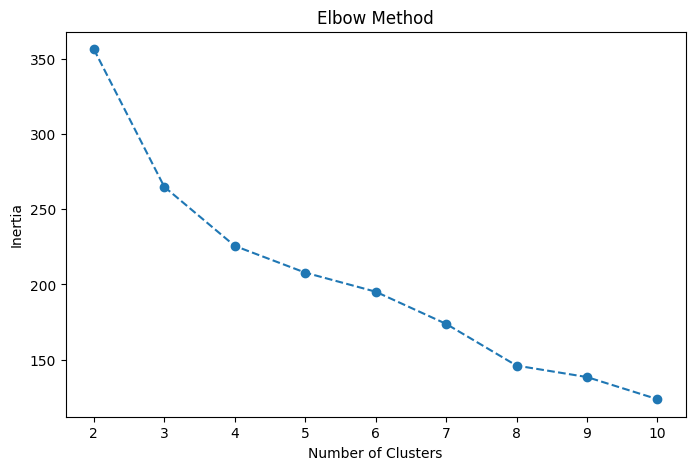

Davies-Bouldin Index: 1.306315421417168


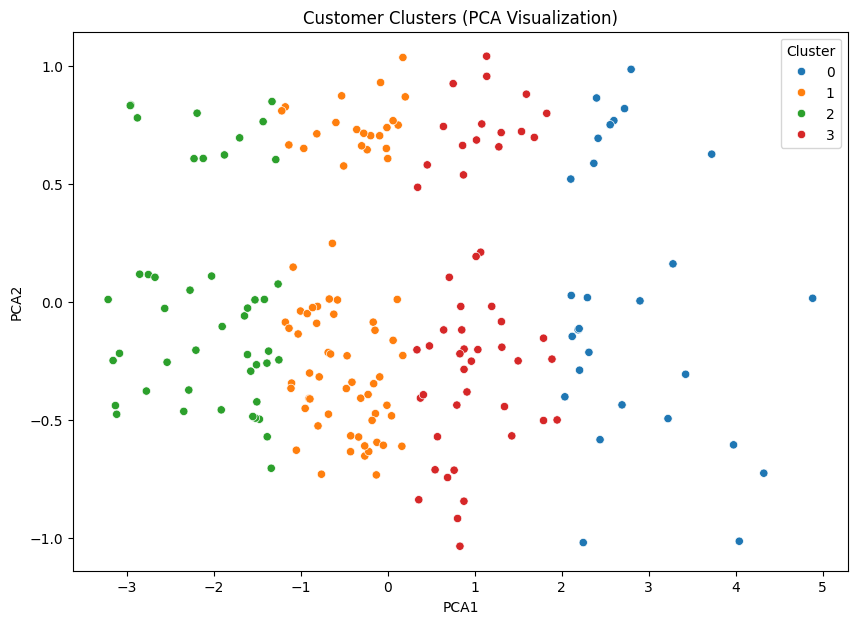

Clustering results saved to 'Customer_Clusters.csv'.


In [16]:
# Step 3: Feature Engineering
# Aggregate transaction data at the customer level
customer_data = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'  # Frequency of transactions
}).rename(columns={
    'TransactionID': 'TransactionFrequency'
}).reset_index()

# Add profile information (e.g., Region)
customer_data = pd.merge(customer_data, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Step 4: Data Preprocessing
# Normalize numerical features
numerical_features = ['TotalValue', 'Quantity', 'TransactionFrequency']
scaler = StandardScaler()
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])

# Encode categorical features
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Drop CustomerID (not needed for clustering)
customer_features = customer_data.drop('CustomerID', axis=1)

# Step 5: Apply K-Means Clustering
# Determine the optimal number of clusters using the elbow method
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (e.g., 4 for this example)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(customer_features)

# Assign clusters to customers
customer_data['Cluster'] = kmeans.labels_

# Step 6: Evaluate Clustering with DB Index
db_index = davies_bouldin_score(customer_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

# Step 7: Visualize Clusters
# Use PCA for 2D visualization
pca = PCA(n_components=2)
customer_pca = pca.fit_transform(customer_features)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PCA1': customer_pca[:, 0],
    'PCA2': customer_pca[:, 1],
    'Cluster': customer_data['Cluster']
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=visualization_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Step 8: Save Results
customer_data.to_csv('Customer_Clusters.csv', index=False)
print("Clustering results saved to 'Customer_Clusters.csv'.")
